## Baseline Model Pipeline   

This is the baseline kernel (automatically generated by my bot: aster). In this kernel, an end to end classification pipeline is implemented.

### Contents 

1. Prepare Environment  
2. Preparation and Exploration   
&nbsp;&nbsp;&nbsp;&nbsp; 2.1 Dataset Snapshot and Summary    
&nbsp;&nbsp;&nbsp;&nbsp; 2.2 Target Variable Distribution    
&nbsp;&nbsp;&nbsp;&nbsp; 2.3 Missing Values    
&nbsp;&nbsp;&nbsp;&nbsp; 2.4 Variable Types
&nbsp;&nbsp;&nbsp;&nbsp; 2.5 Variable Correlations (Numerical Fields)
3. Preprocessing  
&nbsp;&nbsp;&nbsp;&nbsp; 3.1 Label Encoding    
&nbsp;&nbsp;&nbsp;&nbsp; 3.2 Missing Values Treatment     
&nbsp;&nbsp;&nbsp;&nbsp; 3.3 Feature Engineering (Text Fields) 
&nbsp;&nbsp;&nbsp;&nbsp; 3.4 Train Test Split    
4. Modelling   
&nbsp;&nbsp;&nbsp;&nbsp; 4.1 Logistic Regression  
&nbsp;&nbsp;&nbsp;&nbsp; 4.2 Random Forest  
&nbsp;&nbsp;&nbsp;&nbsp; 4.3 Extereme Gradient Boosting  
5. Feature Importance   
6. Simple Ensemble
7. Creating Submission

## Step 1: Prepare Environment
Lets load the required libraries to be used

In [1]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
import numpy as np 
import itertools

## Step 2: Dataset Preparation and Exploration
Load the train and test dataset into memory

In [2]:
## read dataset
train_df = pd.read_csv('../input/train 2.csv')
test_df = pd.read_csv("../input/test 2.csv")

## get predictor and target variables
_target = "author"
_id = "id" 

Y = train_df[_target]
distinct_Y = Y.value_counts().index
test_id = test_df[_id]

## drop the target and id columns
train_df = train_df.drop([_target, _id], axis=1)
test_df = test_df.drop([_id], axis=1)


## flag variables generated by bot (used to write the relevant code)
textcol = "text"
tag = "doc"

### 2.1 Dataset snapshot and summary

In [3]:
## snapshot of train and test
train_df.head()

,text
0,"This process, however, afforded me no means of..."
1,It never once occurred to me that the fumbling...
2,"In his left hand was a gold snuff box, from wh..."
3,How lovely is spring As we looked from Windsor...
4,"Finding nothing else, not even gold, the Super..."


### 2.2 Target variable distribution

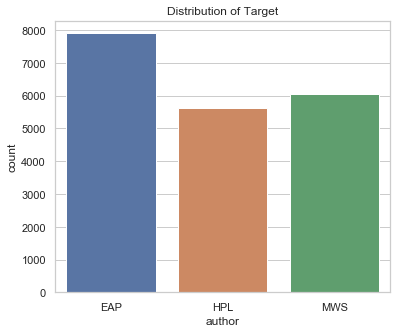

In [4]:
tar_dist = dict(Counter(Y.values))

xx = list(tar_dist.keys())
yy = list(tar_dist.values())

plt.figure(figsize=(6,5))
sns.set(style="whitegrid")
ax = sns.barplot(x=xx, y=yy)
ax.set_title('Distribution of Target')
ax.set_ylabel('count');
ax.set_xlabel(_target);

### 2.3 Missing Value Counts

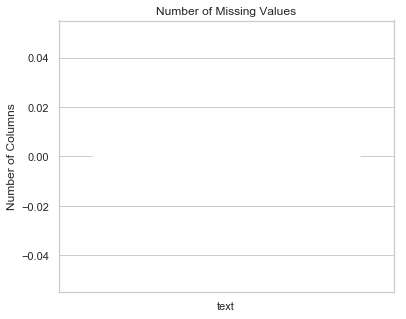

In [5]:
mcount = train_df.isna().sum()
xx = mcount.index 
yy = mcount.values

plt.figure(figsize=(6,5))
sns.set(style="whitegrid")
ax = sns.barplot(x=xx, y=yy)
ax.set_title('Number of Missing Values')
ax.set_ylabel('Number of Columns');

## Step 3: Data Preprocessing

In the data preprocessing step, we will perform label encoding of categorical variables and handle missing values.

### 3.1 Label Encoding
In this step, convert the categorical variables into label encoded forms

In [6]:
if tag != "doc":
    columns = train_df.columns
    num_cols = train_df._get_numeric_data().columns
    cat_cols = list(set(columns) - set(num_cols))

    for col in cat_cols: 
        le = LabelEncoder()
        le.fit(list(train_df[col].values) + list(test_df[col].values))
        train_df[col] = le.transform(list(train_df[col].values))
        test_df[col] = le.transform(list(test_df[col].values))

if Y.dtype.name == "object":
    le = LabelEncoder()
    Y = le.fit_transform(Y.values)

### 3.2 Missing Values Treatment

Handle the missing values, for continuous variables, replace by mean. For categorical variables, replace by mode

In [7]:
if tag != "doc":
    ## for numerical columns, replace the missing values by mean
    train_df[num_cols] = train_df[num_cols].fillna(train_df[num_cols].mean())
    test_df[num_cols] = test_df[num_cols].fillna(test_df[num_cols].mean())

    ## for categorical columns, replace the missing values by mode
    train_df[cat_cols] = train_df[cat_cols].fillna(train_df[cat_cols].mode())
    test_df[cat_cols] = test_df[cat_cols].fillna(test_df[cat_cols].mode())

### 3.3 Feature Engineering (only for text fields)

In this section, we will create relevant features which can be used in the modelling

In [8]:
if tag == "doc":
    tfidf = TfidfVectorizer(min_df=3,  max_features=None, analyzer='word', 
                        token_pattern=r'\w{1,}', stop_words = 'english')
    tfidf.fit(list(train_df[textcol].values))
    xtrain =  tfidf.transform(train_df[textcol].values) 
    xtest =  tfidf.transform(test_df[textcol].values)
else:
    xtrain = train_df
    xtest = test_df

### 3.4 Train and Validation sets split

Create the training and validation sets for training the model and validating it

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(xtrain, Y, test_size=0.20, random_state=2018)

## Step 4 : Create baseline model

Next step is the modelling step, lets start with the simple linear model 

### 4.1 : Logistic Regression

Train a binary classifier logistic regression

In [10]:
model = LogisticRegression()
model.fit(X_train, y_train)
valp = model.predict(X_valid)
pred = model.predict(xtest)

def generate_auc(y_valid, valp):
    auc = roc_auc_score(y_valid, valp)
    print('AUC:', auc)

    fpr, tpr, thresholds = roc_curve(y_valid, valp)
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.title('Receiver Operating Characteristic for different ML algorithms')
    plt.plot(fpr, tpr, 'b', label = 'LGBM-AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'upper left')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])

    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## will only plot auc roc if the target is binary
try:
    generate_auc(y_valid,valp)
except:
    pass

<Figure size 576x576 with 0 Axes>

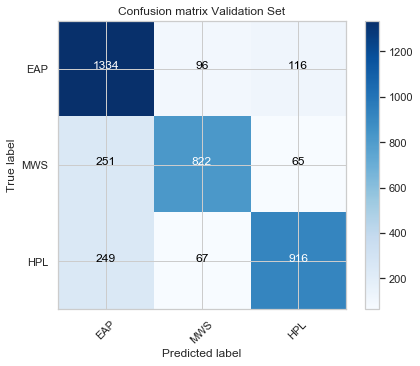

In [11]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix = confusion_matrix(y_valid, valp)
np.set_printoptions(precision=2)

plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=distinct_Y, title='Confusion matrix Validation Set')
plt.show()

### 4.2 : Random Forest Classifier

Now, lets train a tree based model : random forest

In [12]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
valp = model.predict(X_valid)
pred = model.predict(xtest)

## will only plot auc roc if the target is binary
try:
    generate_auc(y_valid,valp)
except:
    pass

<Figure size 432x360 with 0 Axes>

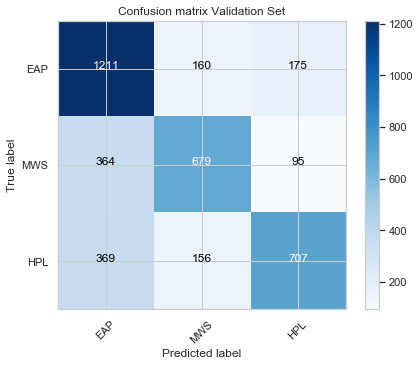

In [13]:
cnf_matrix = confusion_matrix(y_valid, valp)
np.set_printoptions(precision=2)

plt.figure(figsize=(6,5));
plot_confusion_matrix(cnf_matrix, classes=distinct_Y, title='Confusion matrix Validation Set');
plt.show();

### 4.3 : xgBoost Classifier

Lets train the extereme gradient boosting : xgboost classifier

In [14]:
model = xgb.XGBClassifier(n_estimators=300, learning_rate=0.01)
model.fit(X_train, y_train)
valp = model.predict(X_valid)
pred = model.predict(xtest)

## will only plot auc roc if the target is binary
try:
    generate_auc(y_valid,valp)
except:
    pass

NameError: name 'xgb' is not defined

In [ ]:
cnf_matrix = confusion_matrix(y_valid, valp)
np.set_printoptions(precision=2)

plt.figure(figsize=(6,5))
plot_confusion_matrix(cnf_matrix, classes=distinct_Y, title='Confusion matrix Validation Set')
plt.show()

## Step 5: Feature Importance

Lets look at some of the important features

In [16]:
plt.figure(figsize=(6,5))
xgb.plot_importance(model, max_num_features=10);

NameError: name 'xgb' is not defined

<Figure size 432x360 with 0 Axes>

## Step 6 : Ensembling 

Lets create a simple stacking model

## Step 7 : Create Submission File

Finally, create the submission file from the extereme graident boosting model

In [17]:
sub = pd.DataFrame()
sub[_id] = test_id
sub[_target] = pred
sub.to_csv("baseline_submission.csv", index=False)
sub.head(10)

,id,author
0,id02310,2
1,id24541,0
2,id00134,0
3,id27757,0
4,id04081,0
5,id27337,0
6,id24265,0
7,id25917,1
8,id04951,0
9,id14549,0
